In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Author: Xiaopeng Pan
# ID: 1129446
# Purpose: Assignment 3 Part 2
# Date: Mar 26, 2021
# Dataset: https://www.kaggle.com/gasgallo/faces-data-new

# import basic packages
import numpy as np
import matplotlib.pyplot as plt
import os                   # to list the images
import random
import datetime
import time

# to evaluate the performance
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix

# import keras package to create the CNN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, BatchNormalization, \
                                    Dropout, Flatten, Dense, GlobalAveragePooling2D, \
                                    LeakyReLU, UpSampling2D, ZeroPadding2D, Reshape
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

from IPython import display

import warnings   # to disable warning
warnings.filterwarnings('ignore')     

In [ ]:
# build the train set from the images, the original resolution is 180x200, 196x196, resized to 32x32 for easier processing
def build_dataset(data_path):
  if os.path.exists("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy"):
    print("Train set exists!")
    return
  
  file_list = os.listdir(data_path)
  img_list = [f for f in file_list if ".jpg" in f]
  print("There are {} images.".format(len(img_list)))
  print("Building trainset...")
  print("-"*80)

  for idx in range(len(img_list)):
    img_path = data_path + "/" + img_list[idx]
    img = image.load_img(img_path, target_size=(32, 32))
    img_value = image.img_to_array(img)
    img_value = np.expand_dims(img_value, axis=0)
    img_value = img_value.astype(np.uint8)

    if idx==0:
      X = img_value
    else:
      X = np.vstack((X,img_value))

    if idx % 200 == 0:
      print("%5d"%(idx+1),end="")
    elif (idx+1) % 200 == 0:
      print("%5d"%(idx+1))
    else:
      print(".",end="")
  print("{} images processed".format(idx+1))
  np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy",X)
  print("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy saved.")

data_path = r'/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/archive.zip_files/images'
build_dataset(data_path)

There are 7864 images.
Building trainset...
--------------------------------------------------------------------------------
    1......................................................................................................................................................................................................  200
  201......................................................................................................................................................................................................  400
  401......................................................................................................................................................................................................  600
  601......................................................................................................................................................................................................  800
  801..................................

In [7]:
# method to plot image array
def plot_img_array(dataset, num_rows=4, num_cols=4):
  fig = plt.figure(figsize=(10,10))
  for _ in range(1,num_rows*num_cols+1):
    plt.subplot(num_rows, num_cols, _)
    plt.imshow(dataset[_-1],interpolation='nearest')
    plt.axis('off')
  plt.show()

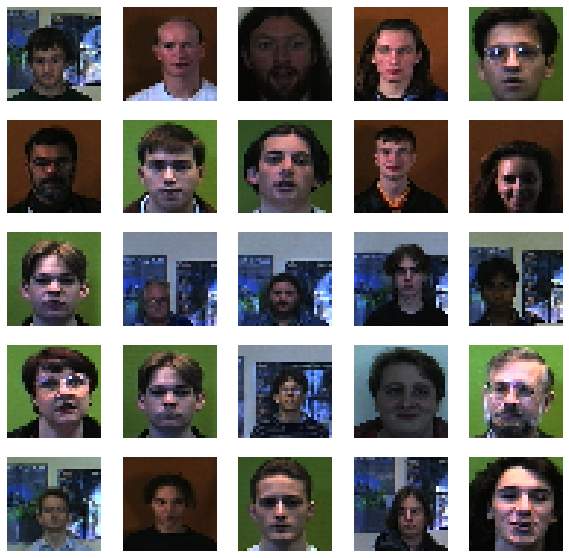

In [10]:
# load the train set
train_set = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy")

# randomly sample images to show
num_sample=25
idx_sample=random.sample(range(0,train_set.shape[0]),num_sample)
dataset_sample=train_set[idx_sample,:,:,:]
plot_img_array(dataset_sample, num_rows=5, num_cols=5)

In [11]:
# method to build the generator model
def get_generator():
    model = Sequential(name="Generator")
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    model.summary()

    return model

In [12]:
# method to build the discriminator model
def get_discriminator():

    model = Sequential(name="Discriminator")

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(32,32,3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    return model

In [13]:
# method to plot loss and accuracy
def plot_loss_acc(data,type,fig_w,fig_h):
  ep = [i for i in range(1,len(data)+1,1)]

  plt.figure(figsize=(fig_w,fig_h))
  plt.plot(ep,data)
  plt.xlabel('epoch')
  plt.ylabel('loss' if 'loss' in type else 'accuracy')
  plt.title(type + ' vs epoch')
  plt.show()

In [14]:
# train the model and save loss and accuracies
def train_gan(model_gen,model_dis,train_dataset,noise_dim = 100,num_epochs=5000,print_image_interval=100,lr_gen=0.0002,lr_dis=0.0001,save_model=True,continued_training=False):
  epochs = num_epochs
  loss = {"Gen":[],"Dis":[]}
  dis_acc = []

  # Instantiate optimizers
  optimizer_gen = Adam(lr_gen, 0.5)
  optimizer_dis = Adam(lr_dis, 0.5)

  # Instantiate a loss function.
  loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

  time_st = time.time()

  # if continue training, load the saved models
  if continued_training:
    model_gen = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_gen.h5")
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_gen.h5 loaded!")
    model_dis = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_dis.h5") 
    print("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_dis.h5 loaded!")

  # loop through epochs
  for epoch in range(epochs):
    # Iterate over the batches of the dataset.
    for x_batch_train in train_dataset:
      # generate noise input
      noise = tf.random.normal([x_batch_train.shape[0], noise_dim])

      # Open a GradientTape to record the operations run during the forward pass, which enables auto-differentiation.
      with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        
        # freeze the generator and train the discriminator
        model_gen.trainable = False
        model_dis.trainable = True

        # output images by the generator
        generated_images = model_gen(noise, training=True)
        
        # build the train set for discriminator
        X_dis = np.concatenate((x_batch_train, generated_images))
        y_dis_for_dis = np.concatenate((np.ones((x_batch_train.shape[0],1)), np.zeros((x_batch_train.shape[0],1))))       # the desired output of discriminator for the train samples and generated images
        
        # obtain the loss of discriminator
        y_dis_for_dis_hat = model_dis(X_dis, training=True)                 # the real output of discriminator for the train samples and the generated images
        dis_loss = loss_fn(y_dis_for_dis,y_dis_for_dis_hat)                 # the loss for the discriminator to update weights

        # obtain the gradients of discriminator
        grads_dis = dis_tape.gradient(dis_loss, model_dis.trainable_weights) 

        # update only the discriminator weights   
        optimizer_dis.apply_gradients(zip(grads_dis, model_dis.trainable_weights))

        # freeze the discriminator and train the generator
        model_gen.trainable = True
        model_dis.trainable = False

        # output images by the generator
        generated_images = model_gen(noise, training=True)

        # obtain the loss of generator
        y_dis_for_gen = np.ones((x_batch_train.shape[0],1))                 # the desired output of discriminator for the generated images
        y_dis_for_gen_hat = model_dis(generated_images, training=True)      # the real output of discriminator for the generated images
        gen_loss = loss_fn(y_dis_for_gen, y_dis_for_gen_hat)                # the loss for the generator to update weights
              
        # obtain the gradients of generator
        grads_gen = gen_tape.gradient(gen_loss, model_gen.trainable_weights)    # update only the generator weights
        
        # update the weights
        optimizer_gen.apply_gradients(zip(grads_gen, model_gen.trainable_weights))
         
          
    # save the loss and discriminator accuracy after each epoch
    loss["Gen"].append(gen_loss)
    loss["Dis"].append(dis_loss)
    
    # print the current loss and discriminator accuracy
    print("Epoch {:4d} Generator Loss:{:2.7f} Discriminator Loss:{:2.7f}".format(epoch+1, gen_loss, dis_loss))
    
    # save the model after each epoch
    if save_model:
      model_gen.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_gen.h5")
      model_dis.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_dis.h5")

    # each 100 epochs, plot images  
    if (epoch+1)%print_image_interval == 0:
      display.clear_output(wait=True)
      img_test = model_gen(tf.random.normal([16, noise_dim]))
      img_test = img_test*127.5+127.5
      img_test = np.array(img_test).astype(np.uint8)
      plot_img_array(img_test, num_rows=4, num_cols=4)
      
  
  print("Training time:%f seconds\n"%(time.time()-time_st))
    
  return loss, dis_acc

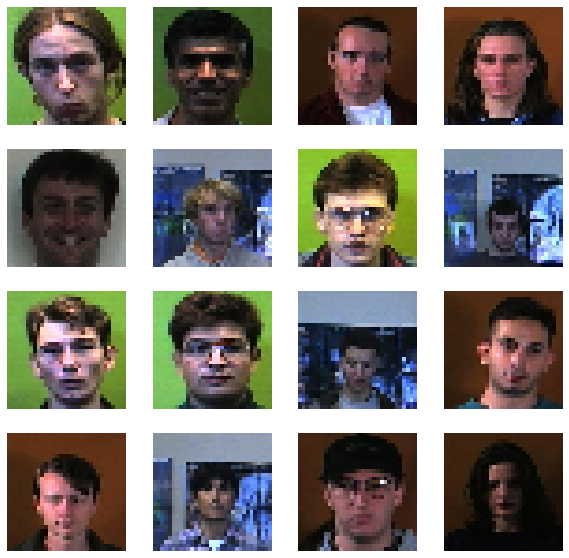

The train set has a shape of (7864, 32, 32, 3)
Build the generator model
--------------------------------------------------------------------------------
Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None,

In [15]:
# load the train set
train_set = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy")

# randomly choose some images to train
num_sample=train_set.shape[0]
idx_sample=random.sample(range(0,train_set.shape[0]),num_sample)
train_set=train_set[idx_sample,:,:,:]
plot_img_array(train_set, num_rows=4, num_cols=4)

# convert the image pixel values from [0,255] to [-1,1]
train_set = train_set.astype(np.float32)
train_set = (train_set - 127.5) / 127.5
print("The train set has a shape of {}".format(train_set.shape))

# prepare the train set
BUFFER_SIZE = train_set.shape[0]
BATCH_SIZE = 512
train_dataset = tf.data.Dataset.from_tensor_slices(train_set).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# create generator and discriminator models
print("Build the generator model")
print("-"*80)
model_gen = get_generator()
print("Build the discriminator model")
print("-"*80)
model_dis = get_discriminator()

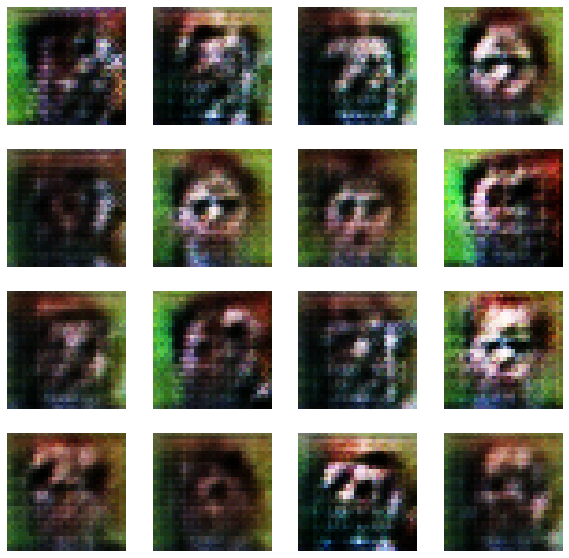

Training time:723.434335 seconds



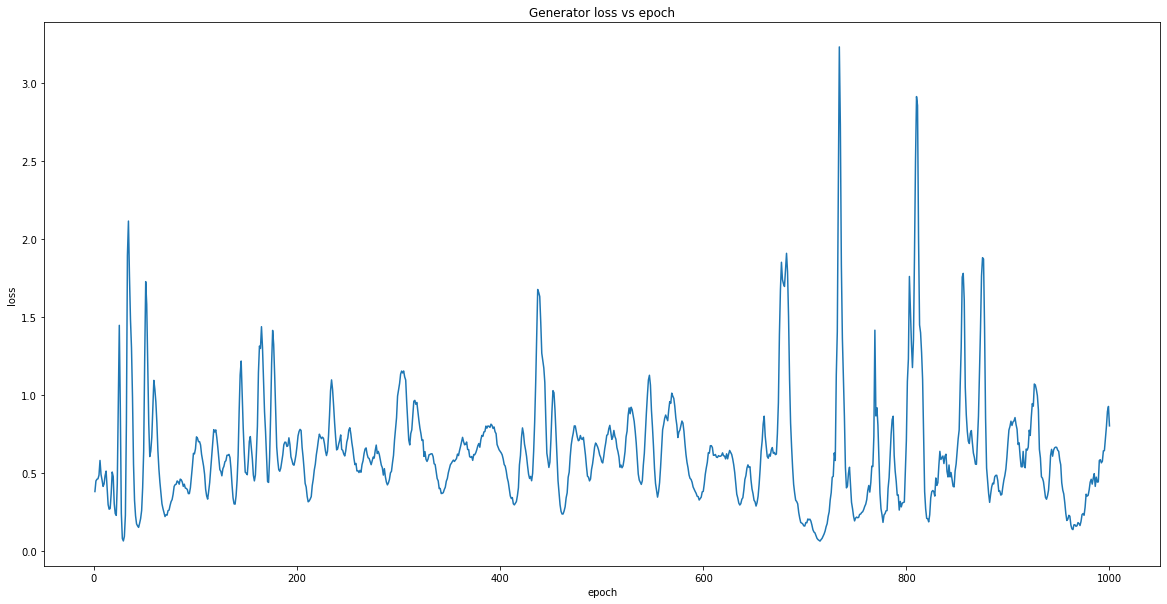

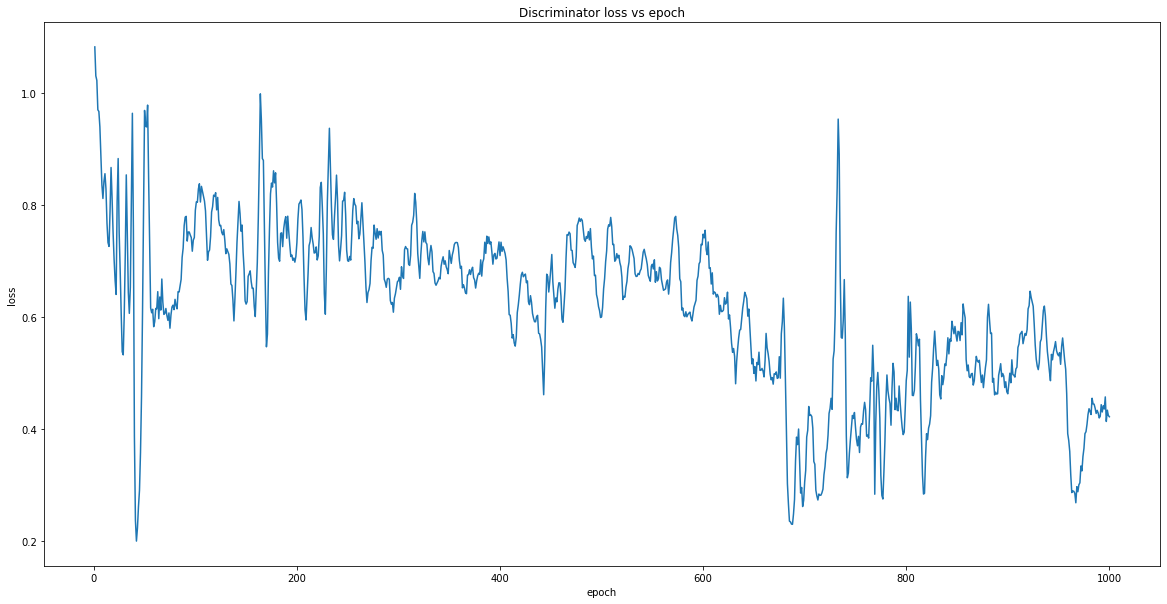

In [ ]:
# train the generator and discriminator
loss, dis_acc = train_gan(model_gen, model_dis, train_dataset, noise_dim = 100, num_epochs=1000,print_image_interval=10,lr_gen=1e-4,lr_dis=1e-4,save_model=True,continued_training=False)
# plot the loss and accuracies during training
plot_loss_acc(loss["Gen"],"Generator loss",20, 10)
plot_loss_acc(loss["Dis"],"Discriminator loss",20, 10)

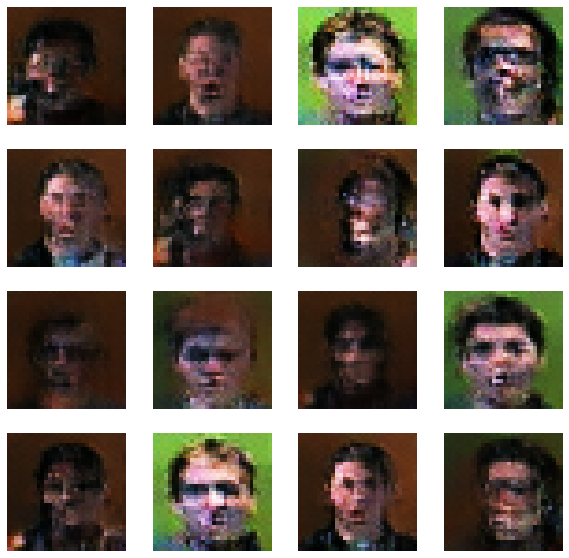

Training time:2444.300621 seconds



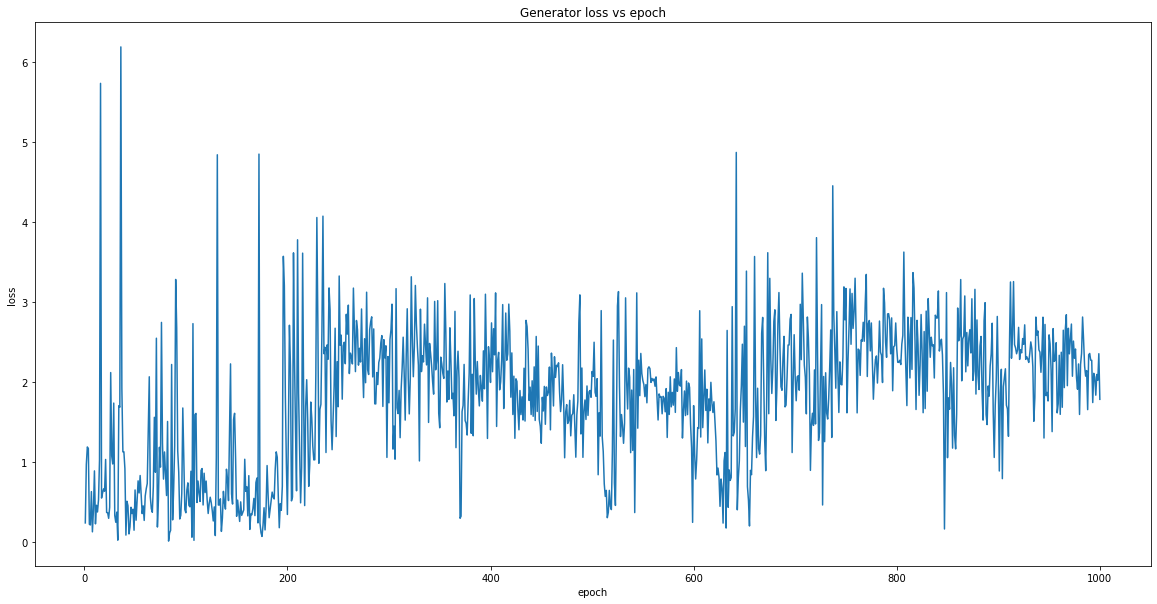

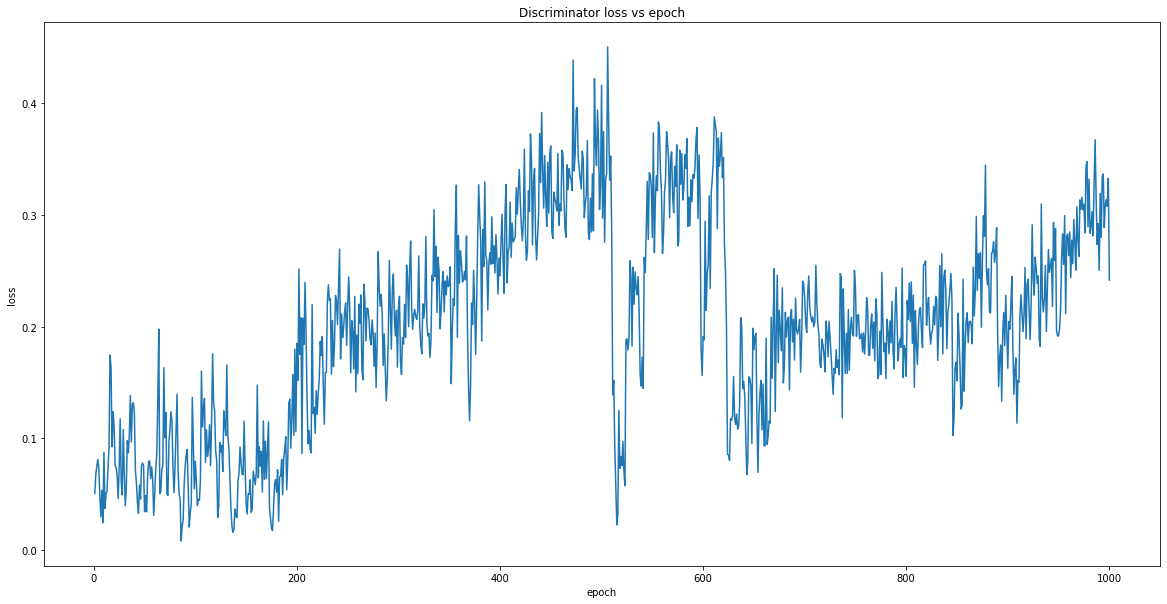

In [12]:
# continuely train the generator and discriminator
loss, dis_acc = train_gan(model_gen, model_dis, train_dataset, noise_dim = 100, num_epochs=1000,print_image_interval=10,lr_gen=1e-4,lr_dis=1e-4,save_model=True,continued_training=True)
# plot the loss and accuracies during training
plot_loss_acc(loss["Gen"],"Generator loss",20, 10)
plot_loss_acc(loss["Dis"],"Discriminator loss",20, 10)

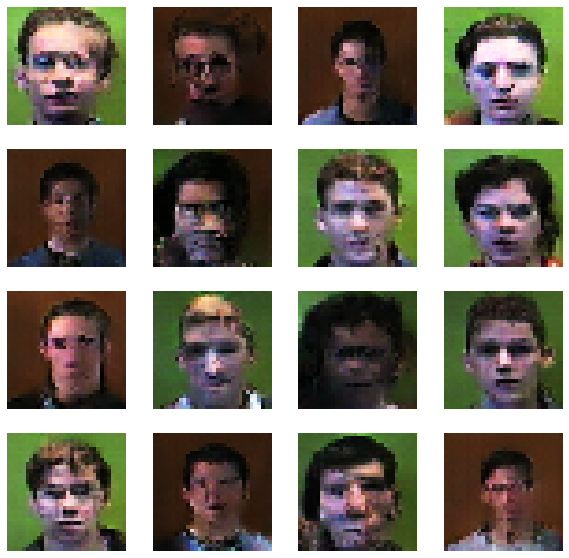

Epoch 4321 Generator Loss:1.7452537 Discriminator Loss:0.3952750
Epoch 4322 Generator Loss:1.2832766 Discriminator Loss:0.3848551


In [ ]:
# continuely train the generator and discriminator
loss, dis_acc = train_gan(model_gen, model_dis, train_dataset, noise_dim = 100, num_epochs=5000,print_image_interval=10,lr_gen=1e-4,lr_dis=1e-4,save_model=True,continued_training=True)
# plot the loss and accuracies during training
plot_loss_acc(loss["Gen"],"Generator loss",20, 10)
plot_loss_acc(loss["Dis"],"Discriminator loss",20, 10)

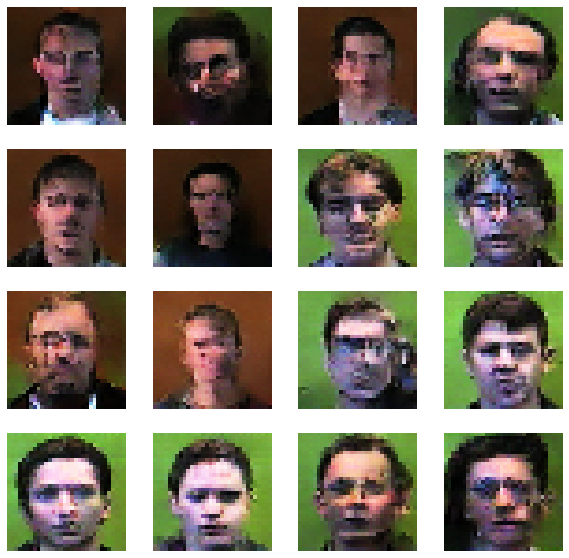

Training time:2481.197448 seconds



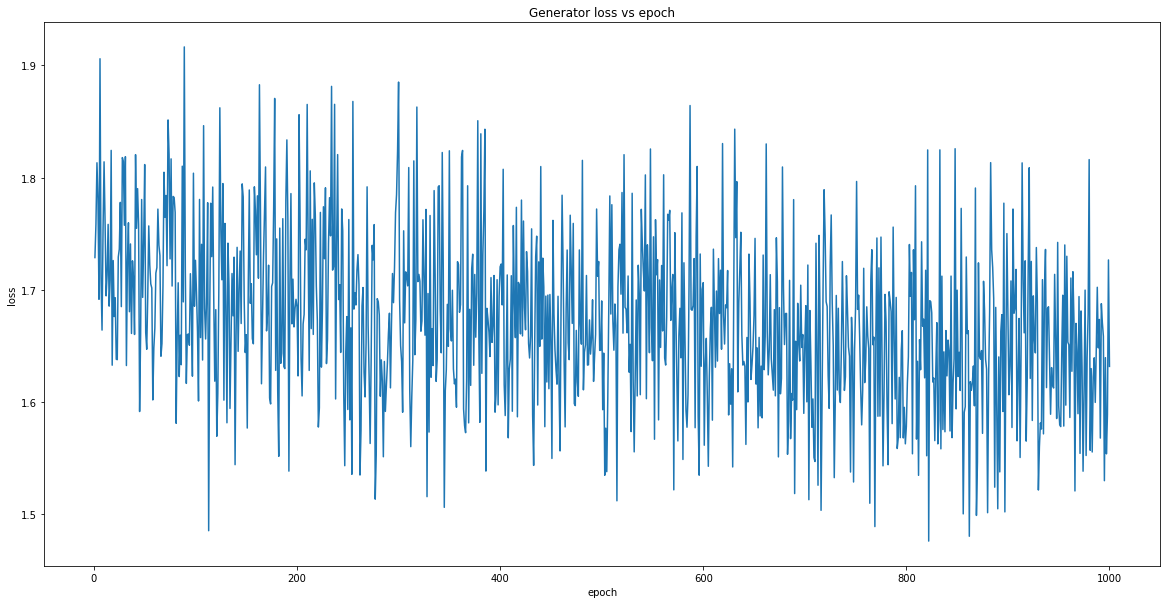

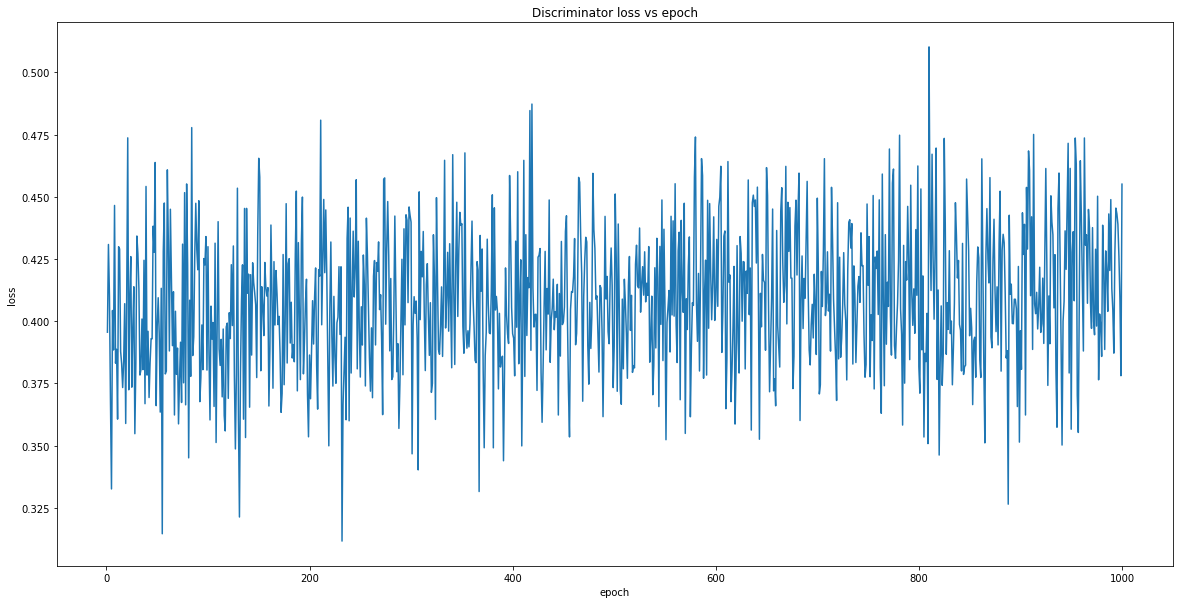

In [16]:
# continuely train the generator and discriminator
loss, dis_acc = train_gan(model_gen, model_dis, train_dataset, noise_dim = 100, num_epochs=1000,print_image_interval=10,lr_gen=1e-5,lr_dis=1e-5,save_model=True,continued_training=True)
# plot the loss and accuracies during training
plot_loss_acc(loss["Gen"],"Generator loss",20, 10)
plot_loss_acc(loss["Dis"],"Discriminator loss",20, 10)

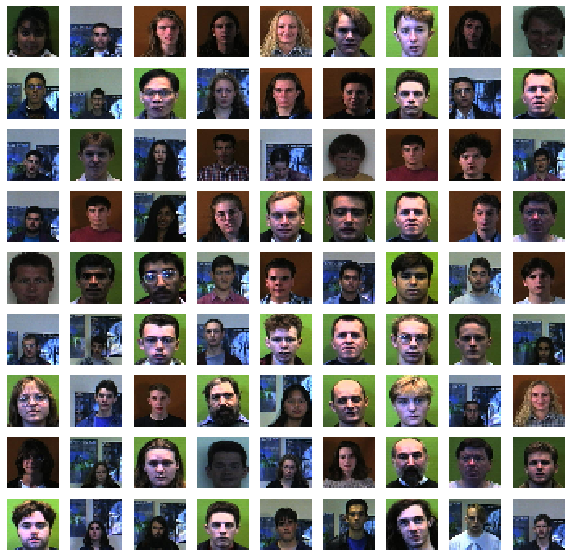

In [46]:
# compare the train images and generated images

# load the train set
train_set = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy")

# randomly sample images to show
num_sample=81
idx_sample=random.sample(range(0,train_set.shape[0]),num_sample)
dataset_sample=train_set[idx_sample,:,:,:]
plot_img_array(dataset_sample, num_rows=9, num_cols=9)

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_11 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0 

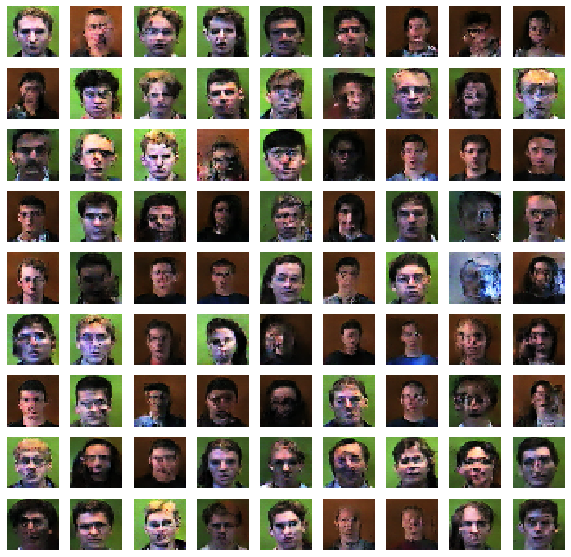

In [61]:
noise_dim = 100

# create the model and load the saved model
model_gen = get_generator()
model_gen = load_model("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_model_p2_gen.h5")

# generate images
img_generated = model_gen(tf.random.normal([train_set.shape[0], noise_dim]))
img_generated = img_generated*127.5+127.5
img_generated = np.array(img_generated).astype(np.uint8)
np.save("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_img_generated.npy",img_generated)
print("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_img_generated.npy saved.")

# randomly sample images to show
num_sample=81
idx_sample=random.sample(range(0,img_generated.shape[0]),num_sample)
dataset_sample=img_generated[idx_sample,:,:,:]
plot_img_array(dataset_sample, num_rows=9, num_cols=9)


In [4]:
# load the datasets
train_set = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_X.npy")
img_generated = np.load("/content/drive/MyDrive/Colab Notebooks/data/dl_a3_dataset_p2/dl_a3_img_generated.npy")

# compare the two images from the train set and the generated set
ssim = tf.image.ssim(train_set[0],img_generated[0],255)
print("The ssim index of the 1st images in the two sets are:", np.array(ssim))

# randomly sample images to compare
num_sample=100
idx_sample=random.sample(range(0,train_set.shape[0]),num_sample)
train_set_sample=train_set[idx_sample,:,:,:]
idx_sample=random.sample(range(0,img_generated.shape[0]),num_sample)
img_generated_sample=img_generated[idx_sample,:,:,:]

# compare each image in the generated sample set to each in the train sample set, for each img, calculate the average ssim
ssim = []
print("Calculating ssim index ...")
for i in range(img_generated_sample.shape[0]):
  ssim_tmp = [np.array(tf.image.ssim(img_generated_sample[i],train_set_sample[j],255)) for j in range(train_set_sample.shape[0])]
  ssim.append(sum(ssim_tmp)/len(ssim_tmp))
  print("Image {:4d} in the generated sample set has been compared to the train sample images, the result is {:1.12f}".format(i+1,sum(ssim_tmp)/len(ssim_tmp)))
print("-"*100)
print("The ssim index of the train set and the generated set is:",sum(ssim)/len(ssim))

The ssim index of the 1st images in the two sets are: 0.062911145
Calculating ssim index ...
Image    1 in the generated sample set has been compared to the train sample images, the result is 0.082104084338
Image    2 in the generated sample set has been compared to the train sample images, the result is 0.110600357838
Image    3 in the generated sample set has been compared to the train sample images, the result is 0.113020450966
Image    4 in the generated sample set has been compared to the train sample images, the result is 0.011046446266
Image    5 in the generated sample set has been compared to the train sample images, the result is 0.088250745867
Image    6 in the generated sample set has been compared to the train sample images, the result is 0.096341126672
Image    7 in the generated sample set has been compared to the train sample images, the result is 0.143024155858
Image    8 in the generated sample set has been compared to the train sample images, the result is 0.10086532